<a href="https://colab.research.google.com/github/KarenOlive/ComputerVision/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build a multi-output CNN model for classification (class names) and object detection (bounding boxes)
The focus was identifying African Wildlife

The dataset is from https://universe.roboflow.com/suranaree-university-of-technology-wqhl6/africa-wild-life/dataset/2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

Download the dataset (tensorflow version) from roboflow

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="4EAIOEqyZgEDusR8CpXi")
project = rf.workspace("suranaree-university-of-technology-wqhl6").project("africa-wild-life")
version = project.version(2)
dataset = version.download("tensorflow")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to africa-wild-life-2 in tensorflow:: 100%|██████████| 2361/2361 [00:01<00:00, 2059.43it/s]


Load the dataset and the csv files

> Visualize the dataset to understand its structure



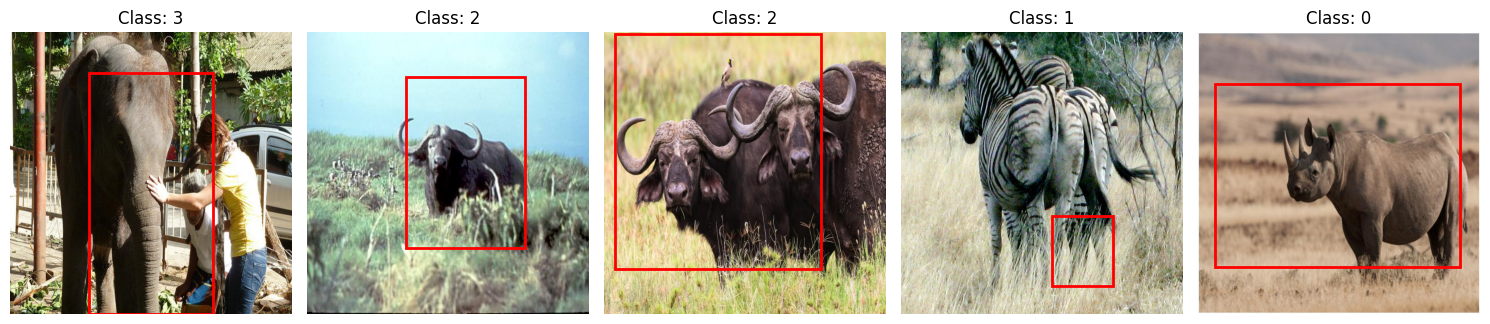

In [4]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import pandas as pd

# Path to the downloaded dataset
dataset_dir = "/content/africa-wild-life-2"  # Default folder where Roboflow downloads the dataset

# Load the annotations file (e.g., `train/_annotations.csv`)
annotations_path = os.path.join(dataset_dir, "train", "_annotations.csv")
annotations = pd.read_csv(annotations_path)

# Path to the images directory
images_dir = os.path.join(dataset_dir, "train")

# Function to visualize images with bounding boxes
def plot_sample_images(data, image_dir, num_samples=5):
    samples = data.sample(num_samples)  # Randomly select rows
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, ax in enumerate(axes):
        row = samples.iloc[i]
        img_path = os.path.join(image_dir, row['filename'])

        try:
            # Open the image
            img = Image.open(img_path)
            ax.imshow(img)

            # Get bounding box coordinates
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

            # Draw bounding box
            rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Display class label
            ax.set_title(f"Class: {row['class']}")
            ax.axis("off")
        except FileNotFoundError:
            ax.set_title("Image Not Found")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to visualize images
plot_sample_images(annotations, images_dir, num_samples=5)


In [5]:
print(annotations['class'].value_counts())


class
3    1159
1    1033
2     776
0     704
Name: count, dtype: int64


In [6]:
print(annotations['class'].unique())


[3 0 1 2]


Since labels are not provided in this dataset. A calssmappings dictionary is created to map the class ids to the animal classes

In [7]:
classmapping = {0: "rhino", 1: "zebra", 2: "buffalo", 3: "elephant"}
print(classmapping[0])
print(classmapping[1])
print(classmapping[2])
print(classmapping[3])


rhino
zebra
buffalo
elephant


In [8]:
annotations['class_name'] = annotations['class'].map(classmapping) #It creates a new colum class_names in annotations

Visualize the csv file after mapping has been done

In [9]:
print(annotations.head())

                                          filename  width  height  class  \
0  248_jpg.rf.6040ddc71c405315a2ebc6b33d29f9c1.jpg    640     640      3   
1  248_jpg.rf.6040ddc71c405315a2ebc6b33d29f9c1.jpg    640     640      3   
2  282_jpg.rf.608be9e22a919a037d14d25ed7d24792.jpg    640     640      3   
3  088_jpg.rf.60aab00b06b742cfaaa37be413738a12.jpg    640     640      0   
4  017_jpg.rf.6043069a82d6e9d8ea304ccc602d09a4.jpg    640     640      1   

   xmin  ymin  xmax  ymax class_name  
0   204   197   608   599   elephant  
1    41    46   403   559   elephant  
2     0   109   401   636   elephant  
3    68    46   602   615      rhino  
4     5    48   422   624      zebra  


Visualize the images again but this time with their respective class labels


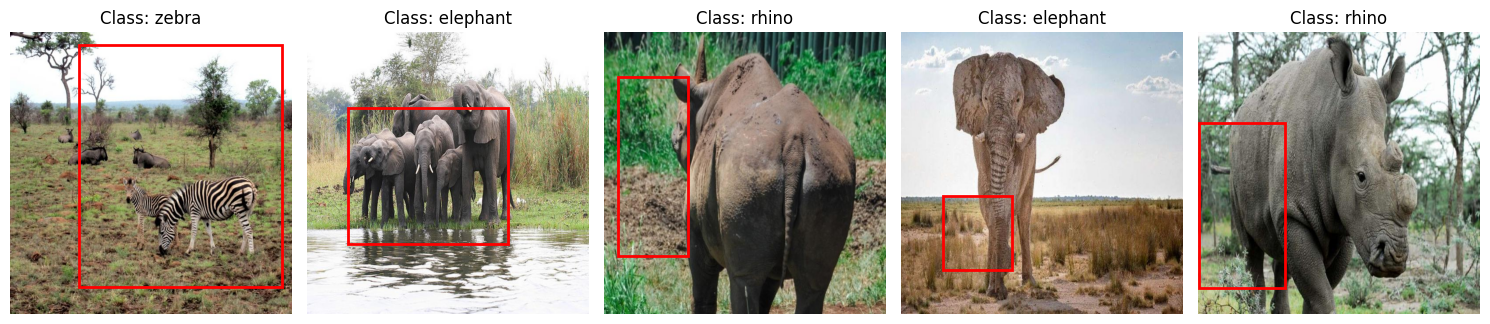

In [11]:
# Function to visualize images with bounding boxes and class mappings
def plot_sample_images(data, image_dir, num_samples=5):
    samples = data.sample(num_samples)  # Randomly select rows
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, ax in enumerate(axes):
        row = samples.iloc[i]
        img_path = os.path.join(image_dir, row['filename'])

        try:
            # Open the image
            img = Image.open(img_path)
            ax.imshow(img)

            # Get bounding box coordinates
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

            # Draw bounding box
            rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # Display class label
            ax.set_title(f"Class: {classmapping[row['class']]}")
            ax.axis("off")
        except FileNotFoundError:
            ax.set_title("Image Not Found")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to visualize images
plot_sample_images(annotations, images_dir, num_samples=5)

Pre-processing of images and splitting of data into valid and train sets

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


# Class mappings
num_classes = len(classmapping)

# Extract bounding boxes and class labels
def preprocess_data(data, image_dir, target_size=(128, 128)): # The function expects 'data' as input
    images = []
    bboxes = []
    classes = []

    # Iterate over rows of the input DataFrame 'data'
    for _, row in data.iterrows():
        img_path = os.path.join(image_dir, row['filename'])
        try:
            # Load and resize image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize

            # Append image, bounding box, and class
            images.append(img_array)
            bboxes.append([row['xmin'], row['ymin'], row['xmax'], row['ymax']])
            classes.append(row['class'])
        except FileNotFoundError:
            print(f"File not found: {img_path}")

    # Convert to numpy arrays
    images = np.array(images)
    bboxes = np.array(bboxes)
    classes = to_categorical(classes, num_classes=num_classes)

    return images, bboxes, classes

# Prepare the data
images_dir = os.path.join(dataset_dir, "train")
images, bboxes, classes = preprocess_data(annotations, images_dir) # Pass 'annotations' as 'data'

# Split data into train, validation, and test sets
X_train_val, X_test, bbox_train_val, bbox_test, class_train_val, class_test = train_test_split(
    images, bboxes, classes, test_size=0.2, random_state=42
)

# Further split train_val into train and validation sets
X_train, X_val, bbox_train, bbox_val, class_train, class_val = train_test_split(
    X_train_val, bbox_train_val, class_train_val, test_size=0.25, random_state=42
)

# Print dataset shapes
print(f"Training data: {X_train.shape}, Bounding boxes: {bbox_train.shape}, Classes: {class_train.shape}")

Training data: (2202, 128, 128, 3), Bounding boxes: (2202, 4), Classes: (2202, 4)


Build the Multi-Output CNN Model


In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Input layer
input_layer = Input(shape=(128, 128, 3))

# Shared CNN layers
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# Bounding box regression branch
bbox_branch = Dense(128, activation='relu')(x)
bbox_branch = Dense(64, activation='relu')(bbox_branch)
bbox_output = Dense(4, activation='linear', name='bbox_output')(bbox_branch)  # Outputs (xmin, ymin, xmax, ymax)

# Classification branch
class_branch = Dense(128, activation='relu')(x)
class_branch = Dropout(0.5)(class_branch)
class_output = Dense(num_classes, activation='softmax', name='class_output')(class_branch)  # Outputs class probabilities

# Define the model
md = Model(inputs=input_layer, outputs=[bbox_output, class_output])

# Compile the model with a multi-output loss
md.compile(
    optimizer='adam',
    loss={
        'bbox_output': 'mse',  # Mean Squared Error for bounding boxes
        'class_output': 'categorical_crossentropy'  # Cross-entropy for class labels
    },
    metrics={
        'bbox_output': 'mae',  # Mean Absolute Error for bounding boxes
        'class_output': 'accuracy'  # Accuracy for classification
    }
)

# Print model summary
md.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 126, 126, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 63, 63, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 61, 61, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 57600)          │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      7,372,928 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │      7,372,928 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bbox_output (Dense)       │ (None, 4)              │            260 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class_output (Dense)      │ (None, 4)              │            516 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,774,280 (56.36 MB)

 Trainable params: 14,774,280 (56.36 MB)

 Non-trainable params: 0 (0.00 B)

Train the multi-output model

In [14]:
# Train the model
history = md.fit(
    X_train,
    {'bbox_output': bbox_train, 'class_output': class_train},
    validation_data=(X_val, {'bbox_output': bbox_val, 'class_output': class_val}),
    epochs=10,
    batch_size=32
)

# Save the model
md.save("wildlife_multi_output_model.h5")
print("Model saved as 'wildlife_multi_output_model.h5'")


Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - bbox_output_loss: 56225.4531 - bbox_output_mae: 180.6115 - class_output_accuracy: 0.3099 - class_output_loss: 3.5473 - loss: 56229.6914 - val_bbox_output_loss: 17429.4883 - val_bbox_output_mae: 107.1457 - val_class_output_accuracy: 0.4884 - val_class_output_loss: 1.3288 - val_loss: 17434.3574
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - bbox_output_loss: 18257.6367 - bbox_output_mae: 108.8375 - class_output_accuracy: 0.3730 - class_output_loss: 1.3424 - loss: 18259.1426 - val_bbox_output_loss: 17497.0156 - val_bbox_output_mae: 109.2053 - val_class_output_accuracy: 0.3184 - val_class_output_loss: 1.3788 - val_loss: 17500.8730
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - bbox_output_loss: 17715.1992 - bbox_output_mae: 107.6312 - class_output_accuracy: 0.3237 - class_output_loss: 1.3769 - loss: 17716.5527 - val_bbox_output_loss: 17327.7051 - val_bbox_output_mae: 109.0425 - val_class_output_accuracy: 0.3184 - val_class_outpu

Model saved as 'wildlife_multi_output_model.h5'


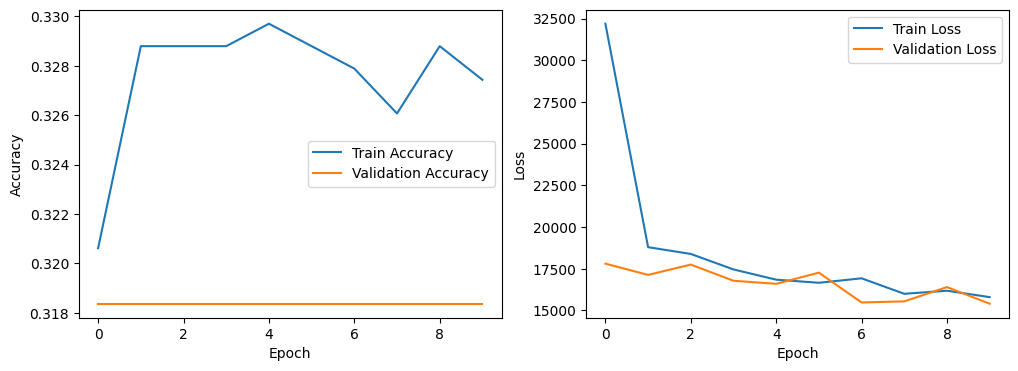

In [13]:
# Plot accuracy and loss over epochs
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
# Access accuracy using 'class_output_accuracy'
plt.plot(history.history['class_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
# Access the total loss using 'loss'
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate the model to understand it's performance

In [15]:
from sklearn.preprocessing import LabelBinarizer

#Evaluate the model
evaluation = md.evaluate(
    X_val,
    {'bbox_output': bbox_val, 'class_output': class_val}
)
# Make predictions on the test set
predictions = md.predict(X_test)

# Extract bounding box and class predictions
bbox_preds = predictions[0]
class_preds = predictions[1]

# Get class labels from class probabilities
class_pred_labels = np.argmax(class_preds, axis=1)

# Assuming class_test is one-hot encoded, convert it to single-label format
# if it's already in single-label format, this step won't change anything
lb = LabelBinarizer()
lb.fit(class_test)  # Fit the binarizer to your labels

if len(class_test.shape) > 1 and class_test.shape[1] > 1:
    class_test = np.argmax(class_test, axis=1)

# Calculate classification metrics
accuracy = accuracy_score(class_test, class_pred_labels)
precision = precision_score(class_test, class_pred_labels, average='weighted', zero_division=0)
recall = recall_score(class_test, class_pred_labels, average='weighted')
f1 = f1_score(class_test, class_pred_labels, average='weighted')

# Print classification metrics
print("Classification Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# --- Bounding Box Metrics ---

print(f"Mean Absolute Error (MAE) for Bounding Boxes: {evaluation[1]}")
print(f"Mean Squared Error (MSE) for Bounding Boxes: {evaluation[2]}")



23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - bbox_output_loss: 16556.8320 - bbox_output_mae: 100.7503 - class_output_accuracy: 0.5125 - class_output_loss: 1.0888 - loss: 16558.1875
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step
Classification Metrics:
Accuracy: 0.48027210884353744
Precision: 0.31960691141169434
Recall: 0.48027210884353744
F1-Score: 0.3737387570270413
Mean Absolute Error (MAE) for Bounding Boxes: 15890.6259765625
Mean Squared Error (MSE) for Bounding Boxes: 1.0921975374221802


CONFUSION MATRIX

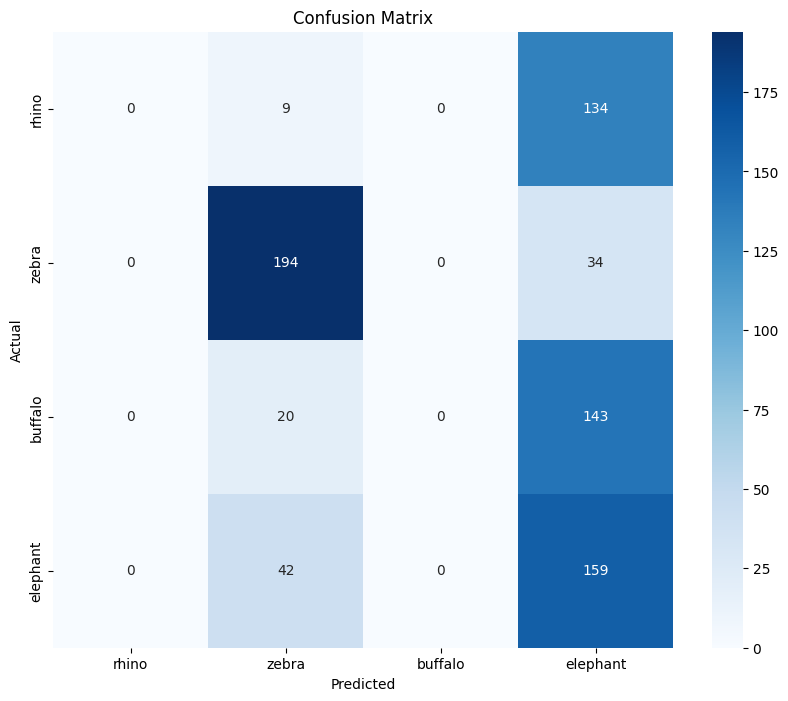

In [21]:
# Confusion Matrix
# Assuming you have already made predictions on your test data (X_test)
# and stored the predictions in a variable called 'class_preds'
class_pred_labels = np.argmax(class_preds, axis=1)

conf_matrix = confusion_matrix(class_test, class_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
           xticklabels=classmapping.values(),  # Use class names for labels
            yticklabels=classmapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

VISUALIZE PREDICTIONS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


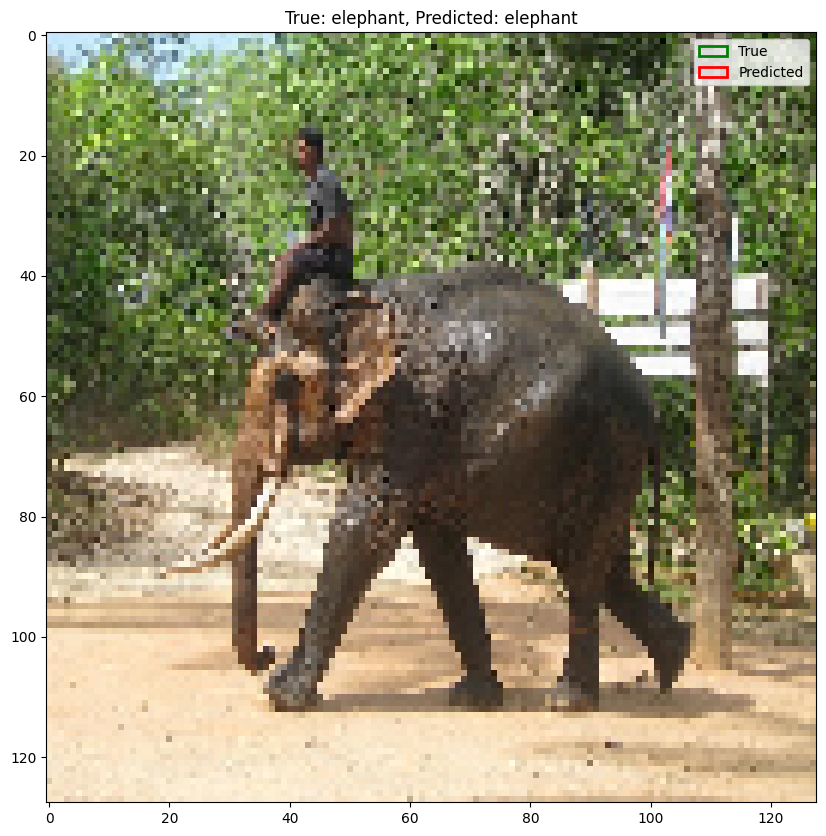

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Function to visualize predictions
def visualize_predictions(image, bbox_true, bbox_pred, class_true, class_pred):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)

    # True bounding box
    rect_true = Rectangle((bbox_true[0], bbox_true[1]), bbox_true[2] - bbox_true[0], bbox_true[3] - bbox_true[1],
                          linewidth=2, edgecolor='green', facecolor='none', label='True')
    ax.add_patch(rect_true)

    # Predicted bounding box
    rect_pred = Rectangle((bbox_pred[0], bbox_pred[1]), bbox_pred[2] - bbox_pred[0], bbox_pred[3] - bbox_pred[1],
                          linewidth=2, edgecolor='red', facecolor='none', label='Predicted')
    ax.add_patch(rect_pred)

    # Display class labels
    ax.set_title(f"True: {classmapping[np.argmax(class_true)]}, Predicted: {classmapping[np.argmax(class_pred)]}")
    ax.legend()
    plt.show()

# Test on a sample image
sample_idx = 0
image = X_val[sample_idx]
bbox_true = bbox_val[sample_idx]
class_true = class_val[sample_idx]

# Predict bounding box and class
bbox_pred, class_pred = md.predict(np.expand_dims(image, axis=0))
bbox_pred = bbox_pred[0]
class_pred = class_pred[0]

# Visualize the result
visualize_predictions(image, bbox_true, bbox_pred, class_true, class_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


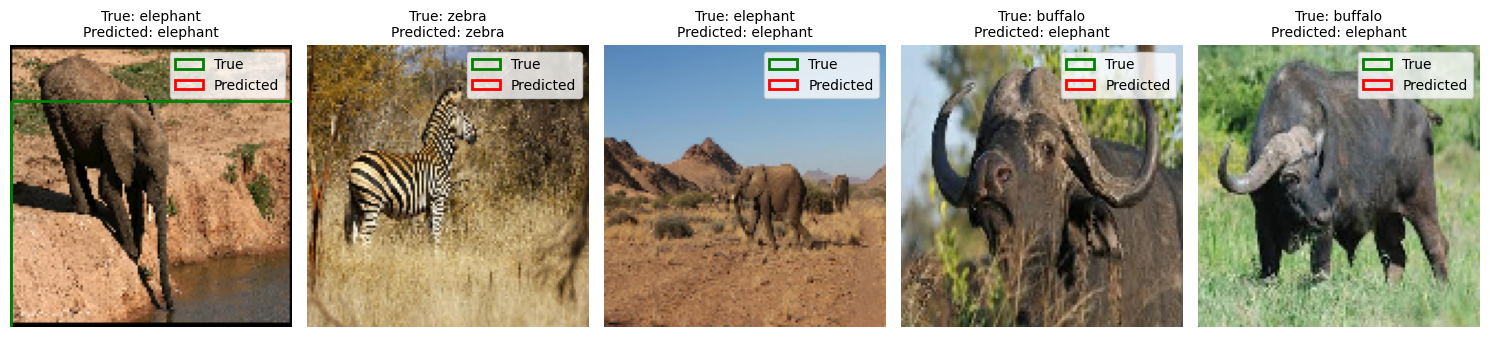

In [22]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# Function to visualize predictions for multiple images
def visualize_predictions_multiple(num_samples=5):
    # Ensure the number of samples does not exceed the dataset size
    num_samples = min(num_samples, len(X_val))

    # Randomly select indices for the samples
    indices = np.random.choice(len(X_val), num_samples, replace=False)

    # Create subplots
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]  # Ensure axes is iterable for a single image case

    for i, idx in enumerate(indices):
        image = X_val[idx]
        bbox_true = bbox_val[idx]
        class_true = class_val[idx]

        # Predict bounding box and class
        bbox_pred, class_pred = md.predict(np.expand_dims(image, axis=0))
        bbox_pred = bbox_pred[0]
        class_pred = class_pred[0]

        # Display image
        axes[i].imshow(image)

        # True bounding box
        rect_true = Rectangle(
            (bbox_true[0], bbox_true[1]),
            bbox_true[2] - bbox_true[0],
            bbox_true[3] - bbox_true[1],
            linewidth=2, edgecolor='green', facecolor='none', label='True'
        )
        axes[i].add_patch(rect_true)

        # Predicted bounding box
        rect_pred = Rectangle(
            (bbox_pred[0], bbox_pred[1]),
            bbox_pred[2] - bbox_pred[0],
            bbox_pred[3] - bbox_pred[1],
            linewidth=2, edgecolor='red', facecolor='none', label='Predicted'
        )
        axes[i].add_patch(rect_pred)

        # Title with true and predicted class
        axes[i].set_title(
            f"True: {classmapping[np.argmax(class_true)]}\nPredicted: {classmapping[np.argmax(class_pred)]}",
            fontsize=10
        )
        axes[i].legend()
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions for multiple images
visualize_predictions_multiple(num_samples=5)


Group images data from dataset into a folder called classified to prepare for feature extraction.
    




In [25]:
import os
import pandas as pd
from pathlib import Path
import shutil

# Paths
# Path to your annotations.csv
images_dir = Path("/content/africa-wild-life-2/train")  # Path to the images directory
output_dir = Path("/content/africa-wild-life-2/classified")  # Path for organized output

# Ensure the output directory exists
output_dir.mkdir(parents=True, exist_ok=True)

train_data = pd.read_csv('/content/africa-wild-life-2/train/_annotations.csv')

# Load annotations
df = train_data

# Group by filename and class
grouped = df.groupby("filename")["class"].first().reset_index()

# Iterate through the grouped data
for _, row in grouped.iterrows():
    filename = row["filename"]  # Image filename
    class_id = row["class"]     # Class ID (integer)
    class_name = classmapping[class_id]  # Class name (e.g., "rhino")

    # Create class folder if it doesn't exist
    class_folder = output_dir / class_name
    class_folder.mkdir(parents=True, exist_ok=True)

    # Source and destination paths
    source_path = images_dir / filename
    dest_path = class_folder / filename

    # Move the image file
    if source_path.exists():
        shutil.move(str(source_path), str(dest_path))
    else:
        print(f"Warning: File {filename} not found in {images_dir}")

print("Images have been grouped by class successfully!")


Images have been grouped by class successfully!


Feature Extraction using the **mobilenet_v2 model** to identify new sub-classes for image classfication
To improve the models accuracy

In [26]:
!pip install tensorflow


In [27]:
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras

m = tf_keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/035-128-feature-vector/2",
                   trainable=False),  # Can be True, see below.
    tf_keras.layers.Dense(num_classes, activation='softmax')
])
m.build([None, 128, 128, 3])  # Batch input shape.


Process images to use with the MobileNetV2

In [28]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # Import preprocess_input

def preprocess_image(image_path):
    # Load the image
    img = load_img(image_path, target_size=(128, 128))
    # Convert the image to an array
    img_array = img_to_array(img)
    # Expand dimensions to match the model input
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess for MobileNetV2
    img_array = preprocess_input(img_array)
    return img_array


Extract features from the model

In [29]:
def extract_features(image_path):
    img_array = preprocess_image(image_path)
    # Extract features using the model
    features = m.predict(img_array)
    return features


In [30]:
image_dir = "/content/africa-wild-life-2/classified"

feature_dict = {}

for animal_class in os.listdir(image_dir):
    class_dir = os.path.join(image_dir, animal_class)
    if os.path.isdir(class_dir):
        feature_dict[animal_class] = []
        for img_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, img_file)
            if img_file.endswith(('.jpg', '.png', '.jpeg')):  # Ensure it's an image
                features = extract_features(image_path)
                feature_dict[animal_class].append(features)


1/1 [==============================] - 0s 29ms/step


Save extracted features for use later

In [31]:
import pickle

with open("features.pkl", "wb") as f:
    pickle.dump(feature_dict, f)


Build a classifier model based off these extracted features

In [32]:
import pickle
import numpy as np

# Load features and labels from the pkl file
with open('features.pkl', 'rb') as f:
    feature_dict = pickle.load(f)  # Load only the dictionary
features = []
labels = []
for animal_class, class_features in feature_dict.items():
    features.extend(class_features)  # Assuming features are lists/arrays
    labels.extend([animal_class] * len(class_features)) # Create labels based on class

features = np.array(features) # Convert to NumPy array if needed
labels = np.array(labels)  # Convert to NumPy array if needed
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")



Features shape: (2060, 1, 4)
Labels shape: (2060,)


In [33]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")


Training set size: (1648, 1, 4)
Validation set size: (412, 1, 4)


In [34]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder to convert string labels to numerical indices
label_encoder = LabelEncoder()

# Fit the encoder on all unique labels
label_encoder.fit(np.unique(labels))

# Transform the training and validation labels
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Reshape X_train and X_val to have the correct input shape
X_train = X_train.reshape(X_train.shape[0], -1) #-1 infers the correct dimension
X_val = X_val.reshape(X_val.shape[0], -1) #-1 infers the correct dimension

# Define the classifier model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(X_train.shape[1],)),  # Features input shape
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(labels)), activation='softmax')  # Adjust for number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 256)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,692 (135.52 KB)

 Trainable params: 34,692 (135.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2439 - loss: 1.3876 - val_accuracy: 0.2816 - val_loss: 1.3755
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3131 - loss: 1.3720 - val_accuracy: 0.2840 - val_loss: 1.3664
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3313 - loss: 1.3583 - val_accuracy: 0.3058 - val_loss: 1.3654
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3266 - loss: 1.3577 - val_accuracy: 0.2985 - val_loss: 1.3593
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3327 - loss: 1.3475 - val_accuracy: 0.2888 - val_loss: 1.3664
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3451 - loss: 1.3372 - val_accuracy: 0.2937 - val_loss: 1.3616
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3546 - loss: 1.3421 - val_accuracy: 0.2985 - val_loss: 1.3629
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3332 - loss: 1.3494 - val_accuracy: 0.3010 - val_loss:

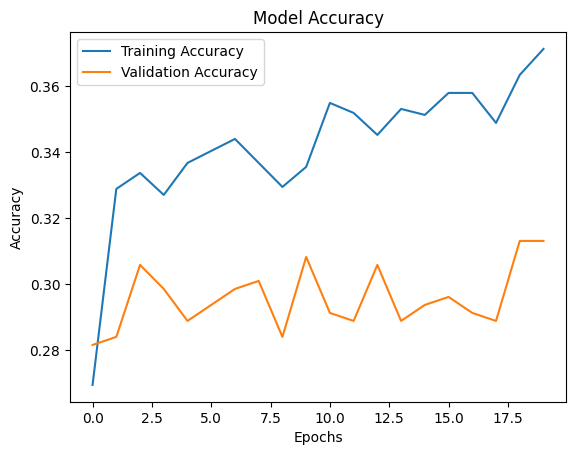

In [35]:
# Train the model
history = model.fit(
    X_train, y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=20,
    batch_size=32,
    verbose=1
)

# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()


In [36]:
# Evaluate on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val_encoded, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.2f}")


Validation Accuracy: 0.31


In [37]:
# Save the trained model
model.save("classification_model.h5")
print("Model saved successfully.")


Model saved successfully.


Group all the test images by classname into the folder test_images

In [39]:
import os
import pandas as pd
from pathlib import Path
import shutil

# Paths
# Path to your annotations.csv
images_dir = Path("/content/africa-wild-life-2/test")  # Path to the images directory
output_dir = Path("/content/africa-wild-life-2/test_images")  # Path for organized output

# Ensure the output directory exists
output_dir.mkdir(parents=True, exist_ok=True)

test_data = pd.read_csv('/content/africa-wild-life-2/test/_annotations.csv')

# Load annotations
df = test_data

# Group by filename and class
grouped = df.groupby("filename")["class"].first().reset_index()

# Iterate through the grouped data
for _, row in grouped.iterrows():
    filename = row["filename"]  # Image filename
    class_id = row["class"]     # Class ID (integer)
    class_name = classmapping[class_id]  # Class name (e.g., "rhino")

    # Create class folder if it doesn't exist
    class_folder = output_dir / class_name
    class_folder.mkdir(parents=True, exist_ok=True)

    # Source and destination paths
    source_path = images_dir / filename
    dest_path = class_folder / filename

    # Move the image file
    if source_path.exists():
        shutil.move(str(source_path), str(dest_path))
    else:
        print(f"Warning: File {filename} not found in {images_dir}")

print("Images have been grouped by class successfully!")


Images have been grouped by class successfully!


Use the classification model to try to make a prediction of a single image through inference. Upload a picture of a wildlife animal

In [42]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mse  # Explicitly import mse
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import os

# Load the model
classification_model = load_model("classification_model.h5", custom_objects={'mse': mse})

# Function to upload file and predict
def predict_animal():
    # Upload image file
    print("Please upload an image file:")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded.")
        return

    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]
    print(f"File uploaded: {image_path}")

    # Load and preprocess the image
    img = load_img(image_path, target_size=(128, 128))  # Adjust target_size if needed
    img_array = img_to_array(img)

    # Feature extraction (adjust according to your model's requirements)
    features = np.array([img_array.mean(), img_array.std(), img_array.min(), img_array.max()])
    img_array = features.reshape(1, -1)  # Reshape to (1, 4)

    # Predict
    predictions = classification_model.predict(img_array)
    class_idx = np.argmax(predictions)

    # Map prediction index to class label (replace 'classmapping' with your actual mapping)
    result = classmapping.get(class_idx, "Unknown")
    print(f"Predicted Animal: {result}")

    # Optionally, remove the uploaded file to keep the environment clean
    os.remove(image_path)

# Call the function
predict_animal()


Please upload an image file:


Saving zebra.jpeg to zebra.jpeg
File uploaded: zebra.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Animal: buffalo


Based on the prediction result, the classifications accuracy is still low

============================================================================


IMPLEMENT TRANSFER LEARNING TO HELP IMPROVE THE ACCURACY OF BOTH THE MULTI-OUTPUT MODEL AND THE CLASSIFICATION MODEL